In [7]:
# ============================================================
# Leukemia Classification — Full Swin Transformer Pipeline (Kaggle-ready)
# Upgraded: fold-wise split (no leakage) + weighted sampler + class-weighted CE
# toned-down medical augs + IMG_SIZE=384, BATCH_SIZE=16 + CutMix + 8-way TTA
# PyTorch >= 1.10, torchvision >= 0.13  ✅ Fixed for PyTorch >= 2.6
# ============================================================

import os, random, time, math, warnings
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torchvision.models import swin_t, swin_b, Swin_T_Weights, Swin_B_Weights

from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score, f1_score

warnings.filterwarnings("ignore")

# ----------------------- CONFIG -----------------------
SEED = 42
BATCH_SIZE = 16                 # ↓ higher res → smaller batch
NUM_CLASSES = 2
EPOCHS = 80
IMG_SIZE = 384                  # ↑ better morphology detail
MIXUP_PROB = 0.6
MIXUP_ALPHA = 0.8
USE_CUTMIX = True
LABEL_SMOOTH = 0.05             # milder smoothing
LR = 5e-5
WEIGHT_DECAY = 2e-4             # a bit stronger regularization
MODEL_CHOICE = "swin_t"         # "swin_t" or "swin_b"
NUM_WORKERS = 4
SAVE_DIR = "./checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

# ✅ Update these paths for your Kaggle dataset
train_dir = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data"
val_dir   = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data"
val_csv   = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv"

# ----------------------- REPRO -----------------------
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(SEED)
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============================================================
# 1) Dataset classes
# ============================================================
class LeukemiaDataset(Dataset):
    def __init__(self, root_dir, folds=None, transform=None):
        self.root_dir, self.transform = root_dir, transform
        self.image_paths, self.labels = [], []
        exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')

        if folds:
            for fold in folds:
                for label, category in enumerate(['all', 'hem']):
                    folder_path = os.path.join(root_dir, fold, category)
                    if not os.path.isdir(folder_path): continue
                    for img_name in os.listdir(folder_path):
                        if img_name.lower().endswith(exts):
                            self.image_paths.append(os.path.join(folder_path, img_name))
                            self.labels.append(label)
        else:
            for label, category in enumerate(['all', 'hem']):
                folder_path = os.path.join(root_dir, category)
                if not os.path.isdir(folder_path): continue
                for img_name in os.listdir(folder_path):
                    if img_name.lower().endswith(exts):
                        self.image_paths.append(os.path.join(folder_path, img_name))
                        self.labels.append(label)

    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform: image = self.transform(image)
        return image, label


class LeukemiaCSVDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir, self.transform = root_dir, transform
        if "new_names" not in self.data.columns or "labels" not in self.data.columns:
            raise ValueError("CSV must contain 'new_names' and 'labels' columns.")
        self.filename_col = "new_names"
        print(f"✅ Using column '{self.filename_col}' for image names.")

    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.data.iloc[idx][self.filename_col]))
        image = Image.open(img_name).convert("RGB")
        label = int(self.data.iloc[idx]["labels"])
        if self.transform: image = self.transform(image)
        return image, label

# ============================================================
# 2) Transforms (morphology-friendly)
# ============================================================
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0), ratio=(0.95, 1.05), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.10, 0.10), shear=5),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.10, hue=0.02),
    transforms.GaussianBlur(3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ============================================================
# 3) Load & Split Data
# ============================================================
train_raw = LeukemiaDataset(train_dir, folds=('fold_0', 'fold_1', 'fold_2'))
val_raw   = LeukemiaCSVDataset(val_csv, val_dir)

all_paths  = train_raw.image_paths + [os.path.join(val_dir, str(x)) for x in val_raw.data[val_raw.filename_col]]
all_labels = train_raw.labels      + list(val_raw.data["labels"])

from sklearn.model_selection import train_test_split
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_paths, all_labels, test_size=0.30, stratify=all_labels, random_state=SEED)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.50, stratify=temp_labels, random_state=SEED)

from collections import Counter
print("✅ Data Split Complete:")
print("Train:", Counter(train_labels))
print("Val:",   Counter(val_labels))
print("Test:",  Counter(test_labels))

class SubsetDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths, self.labels, self.transform = paths, labels, transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        lbl = self.labels[idx]
        if self.transform: img = self.transform(img)
        return img, lbl

train_dataset = SubsetDataset(train_paths, train_labels, transform_train)
val_dataset   = SubsetDataset(val_paths, val_labels, transform_val)
test_dataset  = SubsetDataset(test_paths, test_labels, transform_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)



Device: cuda
✅ Using column 'new_names' for image names.
✅ Data Split Complete:
Train: Counter({0: 5544, 1: 3225})
Val: Counter({0: 1188, 1: 691})
Test: Counter({0: 1188, 1: 692})


In [ ]:
# ============================================================
# 4) Model
# ============================================================
if MODEL_CHOICE == "swin_t":
    weights = Swin_T_Weights.IMAGENET1K_V1
    model = swin_t(weights=weights)
    model_name = "swin_t"
else:
    weights = Swin_B_Weights.IMAGENET1K_V1
    model = swin_b(weights=weights)
    model_name = "swin_b"

in_features = model.head.in_features
model.head = nn.Linear(in_features, NUM_CLASSES)
model = model.to(device)
print(f"✅ Loaded model: {model_name} -> head out_features set to {NUM_CLASSES}")

# ============================================================
# 5) Hybrid Loss (Class-weighted CE + Focal)
# ============================================================
# Class weights (computed from training distribution)
_total = sum(class_counts.values())
w_all = _total / (2 * class_counts[0])
w_hem = _total / (2 * class_counts[1])

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.5):
        super().__init__()
        self.alpha, self.gamma = alpha, gamma
    def forward(self, inputs, targets):
        ce = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce)
        return (self.alpha * (1 - pt) ** self.gamma * ce).mean()

ce_loss_fn = nn.CrossEntropyLoss(
    weight=torch.tensor([w_all, w_hem], device=device, dtype=torch.float32),
    label_smoothing=LABEL_SMOOTH
)
focal_loss_fn = FocalLoss(alpha=1.0, gamma=2.5)

def hybrid_loss(outputs, targets, alpha=0.7):
    return alpha * ce_loss_fn(outputs, targets) + (1 - alpha) * focal_loss_fn(outputs, targets)

# ============================================================
# 6) MixUp / CutMix
# ============================================================
def rand_bbox(size, lam):
    W, H = size[2], size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w, cut_h = int(W * cut_rat), int(H * cut_rat)
    cx, cy = np.random.randint(W), np.random.randint(H)
    bbx1, bby1 = np.clip(cx - cut_w // 2, 0, W), np.clip(cy - cut_h // 2, 0, H)
    bbx2, bby2 = np.clip(cx + cut_w // 2, 0, W), np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def mixup_data(x, y, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    mixed_x = lam * x + (1 - lam) * x[idx, :]
    return mixed_x, y, y[idx], lam

def cutmix_data(x, y, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    y_a, y_b = y, y[idx]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[idx, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2)))
    return x, y_a, y_b, lam

# ============================================================
# 7) Optimizer + Scheduler + AMP
# ============================================================
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
steps_per_epoch = max(1, len(train_loader))
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR, steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS, pct_start=0.3, anneal_strategy='cos', final_div_factor=100
)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

# ============================================================
# 8) Training / Validation
# ============================================================
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    y_true_all, y_pred_all = [], []
    bar = tqdm(train_loader, desc=f"Train[{epoch}]")
    for imgs, labels in bar:
        imgs, labels = imgs.to(device), labels.to(device)
        mixed = False
        if random.random() < MIXUP_PROB:
            imgs, y_a, y_b, lam = (cutmix_data(imgs, labels) if USE_CUTMIX else mixup_data(imgs, labels))
            mixed = True

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            outputs = model(imgs)
            if mixed:
                loss = lam * hybrid_loss(outputs, y_a) + (1 - lam) * hybrid_loss(outputs, y_b)
            else:
                loss = hybrid_loss(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item() * imgs.size(0)
        if not mixed:
            preds = outputs.argmax(dim=1)
            y_true_all.extend(labels.detach().cpu().numpy())
            y_pred_all.extend(preds.detach().cpu().numpy())
        bar.set_postfix({'loss': f"{running_loss / ((bar.n+1)*BATCH_SIZE):.4f}"})
    return running_loss / len(train_dataset), (accuracy_score(y_true_all, y_pred_all) if y_true_all else 0.0)

def validate(epoch, loader=val_loader):
    model.eval()
    running_loss = 0.0
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc=f"Val[{epoch}]"):
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
                outputs = model(imgs)
                loss = hybrid_loss(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            y_true.extend(labels.detach().cpu().numpy())
            y_pred.extend(preds.detach().cpu().numpy())
    return (running_loss / len(loader.dataset),
            accuracy_score(y_true, y_pred),
            f1_score(y_true, y_pred, average='macro'),
            y_true, y_pred)

# ============================================================
# 9) Test-Time Augmentation (8-way)
# ============================================================
def tta_predict(loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="TTA Predict"):
            imgs, labels = imgs.to(device), labels.to(device)
            aug_imgs = [
                imgs,
                torch.flip(imgs, dims=[3]),
                imgs.rot90(1, [2,3]),
                torch.flip(imgs.rot90(1,[2,3]), dims=[3]),
                imgs.rot90(2, [2,3]),
                torch.flip(imgs.rot90(2,[2,3]), dims=[3]),
                imgs.rot90(3, [2,3]),
                torch.flip(imgs.rot90(3,[2,3]), dims=[3]),
            ]
            out_sum = 0
            for im in aug_imgs:
                with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
                    out_sum = out_sum + model(im)
            preds = out_sum.argmax(dim=1).detach().cpu().numpy()
            y_true.extend(labels.detach().cpu().numpy())
            y_pred.extend(preds)
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro'), y_true, y_pred

# ============================================================
# 10) Training Loop — Save Best by Validation Accuracy
# ============================================================
best_val_acc, history = -1.0, []
for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = train_one_epoch(epoch)
    val_loss, val_acc, val_f1, y_true, y_pred = validate(epoch)

    print(f"Epoch {epoch}/{EPOCHS} | Train loss {train_loss:.4f}, acc {train_acc:.4f} | "
          f"Val loss {val_loss:.4f}, acc {val_acc:.4f}, f1 {val_f1:.4f}")

    history.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1
    })

    # ✅ Save best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = os.path.join(SAVE_DIR, f"{model_name}_best_acc_{best_val_acc:.4f}.pth")
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "best_val_acc": best_val_acc,
            "history": history
        }, save_path)
        print("✅ Saved Best Model:", save_path)

# ============================================================
# 11) Final Evaluation — Validation + Test Reports
# ============================================================
best_ckpt = sorted([p for p in os.listdir(SAVE_DIR) if p.startswith(model_name) and p.endswith(".pth")])
if best_ckpt:
    ckpt_path = os.path.join(SAVE_DIR, best_ckpt[-1])
    print("Loading best checkpoint:", ckpt_path)
    data = torch.load(ckpt_path, map_location=device, weights_only=False)  # ✅ PyTorch 2.6 fix
    model.load_state_dict(data["model_state"])
    print(f"✅ Loaded checkpoint with best ACC={data.get('best_val_acc', 0):.4f}")
else:
    print("⚠️ No checkpoint found in", SAVE_DIR)

# ✅ Validation evaluation report
val_loss, val_acc, val_f1, y_true_val, y_pred_val = validate("final_val", loader=val_loader)
print(f"\nValidation — loss: {val_loss:.4f}, acc: {val_acc:.4f}, f1: {val_f1:.4f}")
print("Validation Classification Report:\n", classification_report(y_true_val, y_pred_val))

# ✅ Test evaluation report (with 8-way TTA)
test_acc, test_f1, y_true_tta, y_pred_tta = tta_predict(test_loader)
print(f"\nTest (TTA) — acc: {test_acc:.4f}, f1: {test_f1:.4f}")
print("Test Classification Report (TTA):\n", classification_report(y_true_tta, y_pred_tta))

# ✅ Save predictions CSV
out_df = pd.DataFrame({"true": y_true_tta, "pred": y_pred_tta})
out_path = os.path.join(SAVE_DIR, f"{model_name}_test_predictions.csv")
out_df.to_csv(out_path, index=False)
print("\n✅ Saved predictions CSV at:", out_path)
print("✅ All evaluation steps complete.")


✅ Loaded model: swin_t -> head out_features set to 2


Val[1]: 100%|██████████| 118/118 [00:14<00:00,  8.28it/s]


Epoch 1/80 | Train loss 0.4965, acc 0.6299 | Val loss 0.4586, acc 0.6131, f1 0.6129
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.6131.pth


Val[2]: 100%|██████████| 118/118 [00:14<00:00,  8.20it/s]


Epoch 2/80 | Train loss 0.4702, acc 0.6891 | Val loss 0.4468, acc 0.6323, f1 0.6321
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.6323.pth


Val[3]: 100%|██████████| 118/118 [00:14<00:00,  8.28it/s]


Epoch 3/80 | Train loss 0.4541, acc 0.7143 | Val loss 0.4197, acc 0.7014, f1 0.6968
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.7014.pth


Val[4]: 100%|██████████| 118/118 [00:14<00:00,  8.29it/s]


Epoch 4/80 | Train loss 0.4426, acc 0.7495 | Val loss 0.4640, acc 0.6126, f1 0.6105


Val[5]: 100%|██████████| 118/118 [00:14<00:00,  8.31it/s]


Epoch 5/80 | Train loss 0.4362, acc 0.7597 | Val loss 0.4143, acc 0.7036, f1 0.7019
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.7036.pth


Val[6]: 100%|██████████| 118/118 [00:14<00:00,  8.29it/s]


Epoch 6/80 | Train loss 0.4246, acc 0.7701 | Val loss 0.3566, acc 0.7786, f1 0.7725
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.7786.pth


Val[7]: 100%|██████████| 118/118 [00:14<00:00,  8.30it/s]


Epoch 7/80 | Train loss 0.4195, acc 0.7846 | Val loss 0.4026, acc 0.7813, f1 0.7671
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.7813.pth


Val[8]: 100%|██████████| 118/118 [00:14<00:00,  8.27it/s]


Epoch 8/80 | Train loss 0.4245, acc 0.7760 | Val loss 0.3308, acc 0.8127, f1 0.8070
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.8127.pth


Val[9]: 100%|██████████| 118/118 [00:14<00:00,  8.25it/s]


Epoch 9/80 | Train loss 0.4157, acc 0.7857 | Val loss 0.3468, acc 0.7743, f1 0.7719


Val[10]: 100%|██████████| 118/118 [00:14<00:00,  8.25it/s]


Epoch 10/80 | Train loss 0.4072, acc 0.7939 | Val loss 0.3052, acc 0.8334, f1 0.8262
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.8334.pth


Val[11]: 100%|██████████| 118/118 [00:14<00:00,  8.27it/s]


Epoch 11/80 | Train loss 0.4000, acc 0.8074 | Val loss 0.3291, acc 0.7642, f1 0.7628


Val[12]: 100%|██████████| 118/118 [00:14<00:00,  8.32it/s]


Epoch 12/80 | Train loss 0.3987, acc 0.8117 | Val loss 0.3428, acc 0.8095, f1 0.7986


Val[13]: 100%|██████████| 118/118 [00:14<00:00,  8.31it/s]


Epoch 13/80 | Train loss 0.4017, acc 0.8053 | Val loss 0.3036, acc 0.8318, f1 0.8256


Val[14]: 100%|██████████| 118/118 [00:14<00:00,  8.29it/s]


Epoch 14/80 | Train loss 0.4060, acc 0.8138 | Val loss 0.3102, acc 0.8473, f1 0.8359
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.8473.pth


Val[15]: 100%|██████████| 118/118 [00:14<00:00,  8.26it/s]


Epoch 15/80 | Train loss 0.3909, acc 0.8164 | Val loss 0.3572, acc 0.7509, f1 0.7501


Val[16]: 100%|██████████| 118/118 [00:14<00:00,  8.28it/s]


Epoch 16/80 | Train loss 0.3903, acc 0.8178 | Val loss 0.2936, acc 0.8691, f1 0.8571
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.8691.pth


Val[17]: 100%|██████████| 118/118 [00:14<00:00,  8.30it/s]


Epoch 17/80 | Train loss 0.3847, acc 0.8210 | Val loss 0.3114, acc 0.8648, f1 0.8490


Val[18]: 100%|██████████| 118/118 [00:14<00:00,  8.27it/s]


Epoch 18/80 | Train loss 0.3875, acc 0.8339 | Val loss 0.3731, acc 0.7334, f1 0.7331


Val[19]: 100%|██████████| 118/118 [00:14<00:00,  8.25it/s]


Epoch 19/80 | Train loss 0.3790, acc 0.8204 | Val loss 0.4204, acc 0.7291, f1 0.7280


Val[20]: 100%|██████████| 118/118 [00:14<00:00,  8.32it/s]


Epoch 20/80 | Train loss 0.3820, acc 0.8510 | Val loss 0.2859, acc 0.8590, f1 0.8498


Val[21]: 100%|██████████| 118/118 [00:14<00:00,  8.25it/s]


Epoch 21/80 | Train loss 0.3734, acc 0.8504 | Val loss 0.2639, acc 0.8787, f1 0.8730
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.8787.pth


Val[22]: 100%|██████████| 118/118 [00:14<00:00,  8.33it/s]


Epoch 22/80 | Train loss 0.3669, acc 0.8426 | Val loss 0.2562, acc 0.8824, f1 0.8761
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.8824.pth


Val[23]: 100%|██████████| 118/118 [00:14<00:00,  8.28it/s]


Epoch 23/80 | Train loss 0.3629, acc 0.8542 | Val loss 0.2674, acc 0.8872, f1 0.8779
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.8872.pth


Val[24]: 100%|██████████| 118/118 [00:14<00:00,  8.28it/s]


Epoch 24/80 | Train loss 0.3658, acc 0.8546 | Val loss 0.2686, acc 0.8744, f1 0.8663


Val[25]: 100%|██████████| 118/118 [00:14<00:00,  8.27it/s]


Epoch 25/80 | Train loss 0.3626, acc 0.8628 | Val loss 0.2789, acc 0.8318, f1 0.8287


Val[26]: 100%|██████████| 118/118 [00:14<00:00,  8.26it/s]


Epoch 26/80 | Train loss 0.3542, acc 0.8633 | Val loss 0.2535, acc 0.8909, f1 0.8837
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.8909.pth


Val[27]: 100%|██████████| 118/118 [00:14<00:00,  8.29it/s]


Epoch 27/80 | Train loss 0.3531, acc 0.8648 | Val loss 0.5662, acc 0.6466, f1 0.6458


Val[28]: 100%|██████████| 118/118 [00:14<00:00,  8.27it/s]


Epoch 28/80 | Train loss 0.3495, acc 0.8714 | Val loss 0.2785, acc 0.8536, f1 0.8488


Val[29]: 100%|██████████| 118/118 [00:14<00:00,  8.25it/s]


Epoch 29/80 | Train loss 0.3477, acc 0.8793 | Val loss 0.2958, acc 0.8206, f1 0.8184


Val[30]: 100%|██████████| 118/118 [00:14<00:00,  8.26it/s]


Epoch 30/80 | Train loss 0.3455, acc 0.8812 | Val loss 0.3574, acc 0.8095, f1 0.8045


Val[31]: 100%|██████████| 118/118 [00:14<00:00,  8.26it/s]


Epoch 31/80 | Train loss 0.3386, acc 0.8860 | Val loss 0.2488, acc 0.8914, f1 0.8835
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.8914.pth


Val[32]: 100%|██████████| 118/118 [00:14<00:00,  8.30it/s]


Epoch 32/80 | Train loss 0.3342, acc 0.8895 | Val loss 0.2864, acc 0.8675, f1 0.8606


Val[33]: 100%|██████████| 118/118 [00:14<00:00,  8.24it/s]


Epoch 33/80 | Train loss 0.3310, acc 0.8835 | Val loss 0.2783, acc 0.8744, f1 0.8680


Val[34]: 100%|██████████| 118/118 [00:14<00:00,  8.25it/s]


Epoch 34/80 | Train loss 0.3249, acc 0.8909 | Val loss 0.2514, acc 0.8882, f1 0.8818


Val[35]: 100%|██████████| 118/118 [00:14<00:00,  8.27it/s]


Epoch 35/80 | Train loss 0.3252, acc 0.8950 | Val loss 0.2308, acc 0.9111, f1 0.9057
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.9111.pth


Val[36]: 100%|██████████| 118/118 [00:14<00:00,  8.29it/s]


Epoch 36/80 | Train loss 0.3229, acc 0.9082 | Val loss 0.2174, acc 0.9122, f1 0.9070
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.9122.pth


Val[37]: 100%|██████████| 118/118 [00:14<00:00,  8.26it/s]


Epoch 37/80 | Train loss 0.3197, acc 0.9042 | Val loss 0.2010, acc 0.9239, f1 0.9194
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.9239.pth


Val[38]: 100%|██████████| 118/118 [00:14<00:00,  8.22it/s]


Epoch 38/80 | Train loss 0.3122, acc 0.9157 | Val loss 0.2417, acc 0.9159, f1 0.9090


Val[39]: 100%|██████████| 118/118 [00:14<00:00,  8.26it/s]


Epoch 39/80 | Train loss 0.3166, acc 0.9157 | Val loss 0.2094, acc 0.9223, f1 0.9173


Val[40]: 100%|██████████| 118/118 [00:14<00:00,  8.28it/s]


Epoch 40/80 | Train loss 0.3132, acc 0.9222 | Val loss 0.2251, acc 0.9218, f1 0.9158


Val[41]: 100%|██████████| 118/118 [00:14<00:00,  8.26it/s]


Epoch 41/80 | Train loss 0.3072, acc 0.9154 | Val loss 0.2183, acc 0.9170, f1 0.9119


Val[42]: 100%|██████████| 118/118 [00:14<00:00,  8.29it/s]


Epoch 42/80 | Train loss 0.3072, acc 0.9250 | Val loss 0.2164, acc 0.9218, f1 0.9158


Val[43]: 100%|██████████| 118/118 [00:14<00:00,  8.32it/s]


Epoch 43/80 | Train loss 0.2982, acc 0.9252 | Val loss 0.1964, acc 0.9425, f1 0.9379
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.9425.pth


Val[44]: 100%|██████████| 118/118 [00:14<00:00,  8.28it/s]


Epoch 44/80 | Train loss 0.3020, acc 0.9212 | Val loss 0.2548, acc 0.8930, f1 0.8874


Val[45]: 100%|██████████| 118/118 [00:14<00:00,  8.27it/s]


Epoch 45/80 | Train loss 0.2995, acc 0.9345 | Val loss 0.2020, acc 0.9186, f1 0.9142


Val[46]: 100%|██████████| 118/118 [00:14<00:00,  8.27it/s]


Epoch 46/80 | Train loss 0.2933, acc 0.9302 | Val loss 0.2001, acc 0.9372, f1 0.9329


Val[47]: 100%|██████████| 118/118 [00:14<00:00,  8.26it/s]


Epoch 47/80 | Train loss 0.2969, acc 0.9310 | Val loss 0.2043, acc 0.9271, f1 0.9214


Val[48]: 100%|██████████| 118/118 [00:14<00:00,  8.28it/s]


Epoch 48/80 | Train loss 0.2936, acc 0.9355 | Val loss 0.1964, acc 0.9319, f1 0.9271


Train[49]:  55%|█████▌    | 302/549 [01:43<01:24,  2.92it/s, loss=0.2756]

In [8]:
# ============================================================
# 4) Model
# ============================================================
if MODEL_CHOICE == "swin_t":
    weights = Swin_T_Weights.IMAGENET1K_V1
    model = swin_t(weights=weights)
    model_name = "swin_t"
else:
    weights = Swin_B_Weights.IMAGENET1K_V1
    model = swin_b(weights=weights)
    model_name = "swin_b"

in_features = model.head.in_features
model.head = nn.Linear(in_features, NUM_CLASSES)
model = model.to(device)
print(f"✅ Loaded model: {model_name} -> head out_features set to {NUM_CLASSES}")

# ============================================================
# 5) Hybrid Loss (Class-weighted CE + Focal)
# ============================================================
# Class weights (computed from training distribution)
_total = sum(class_counts.values())
w_all = _total / (2 * class_counts[0])
w_hem = _total / (2 * class_counts[1])

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.5):
        super().__init__()
        self.alpha, self.gamma = alpha, gamma
    def forward(self, inputs, targets):
        ce = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce)
        return (self.alpha * (1 - pt) ** self.gamma * ce).mean()

ce_loss_fn = nn.CrossEntropyLoss(
    weight=torch.tensor([w_all, w_hem], device=device, dtype=torch.float32),
    label_smoothing=LABEL_SMOOTH
)
focal_loss_fn = FocalLoss(alpha=1.0, gamma=2.5)

def hybrid_loss(outputs, targets, alpha=0.7):
    return alpha * ce_loss_fn(outputs, targets) + (1 - alpha) * focal_loss_fn(outputs, targets)

# ============================================================
# 6) MixUp / CutMix
# ============================================================
def rand_bbox(size, lam):
    W, H = size[2], size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w, cut_h = int(W * cut_rat), int(H * cut_rat)
    cx, cy = np.random.randint(W), np.random.randint(H)
    bbx1, bby1 = np.clip(cx - cut_w // 2, 0, W), np.clip(cy - cut_h // 2, 0, H)
    bbx2, bby2 = np.clip(cx + cut_w // 2, 0, W), np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def mixup_data(x, y, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    mixed_x = lam * x + (1 - lam) * x[idx, :]
    return mixed_x, y, y[idx], lam

def cutmix_data(x, y, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    y_a, y_b = y, y[idx]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[idx, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2)))
    return x, y_a, y_b, lam

# ============================================================
# 7) Optimizer + Scheduler + AMP
# ============================================================
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
steps_per_epoch = max(1, len(train_loader))
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR, steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS, pct_start=0.3, anneal_strategy='cos', final_div_factor=100
)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

# ============================================================
# 8) Training / Validation
# ============================================================
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    y_true_all, y_pred_all = [], []
    bar = tqdm(train_loader, desc=f"Train[{epoch}]")
    for imgs, labels in bar:
        imgs, labels = imgs.to(device), labels.to(device)
        mixed = False
        if random.random() < MIXUP_PROB:
            imgs, y_a, y_b, lam = (cutmix_data(imgs, labels) if USE_CUTMIX else mixup_data(imgs, labels))
            mixed = True

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            outputs = model(imgs)
            if mixed:
                loss = lam * hybrid_loss(outputs, y_a) + (1 - lam) * hybrid_loss(outputs, y_b)
            else:
                loss = hybrid_loss(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item() * imgs.size(0)
        if not mixed:
            preds = outputs.argmax(dim=1)
            y_true_all.extend(labels.detach().cpu().numpy())
            y_pred_all.extend(preds.detach().cpu().numpy())
        bar.set_postfix({'loss': f"{running_loss / ((bar.n+1)*BATCH_SIZE):.4f}"})
    return running_loss / len(train_dataset), (accuracy_score(y_true_all, y_pred_all) if y_true_all else 0.0)

def validate(epoch, loader=val_loader):
    model.eval()
    running_loss = 0.0
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc=f"Val[{epoch}]"):
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
                outputs = model(imgs)
                loss = hybrid_loss(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            y_true.extend(labels.detach().cpu().numpy())
            y_pred.extend(preds.detach().cpu().numpy())
    return (running_loss / len(loader.dataset),
            accuracy_score(y_true, y_pred),
            f1_score(y_true, y_pred, average='macro'),
            y_true, y_pred)

# ============================================================
# 9) Test-Time Augmentation (8-way)
# ============================================================
def tta_predict(loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="TTA Predict"):
            imgs, labels = imgs.to(device), labels.to(device)
            aug_imgs = [
                imgs,
                torch.flip(imgs, dims=[3]),
                imgs.rot90(1, [2,3]),
                torch.flip(imgs.rot90(1,[2,3]), dims=[3]),
                imgs.rot90(2, [2,3]),
                torch.flip(imgs.rot90(2,[2,3]), dims=[3]),
                imgs.rot90(3, [2,3]),
                torch.flip(imgs.rot90(3,[2,3]), dims=[3]),
            ]
            out_sum = 0
            for im in aug_imgs:
                with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
                    out_sum = out_sum + model(im)
            preds = out_sum.argmax(dim=1).detach().cpu().numpy()
            y_true.extend(labels.detach().cpu().numpy())
            y_pred.extend(preds)
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro'), y_true, y_pred

# ============================================================
# ============================================================
# 10) Training Loop — Resume Supported + Auto-Save Every 5 Epochs
# ============================================================

best_val_acc, history, start_epoch = -1.0, [], 1
ckpt_files = sorted([p for p in os.listdir(SAVE_DIR) if p.startswith(model_name) and p.endswith(".pth")])

# ✅ Try to resume from latest checkpoint
if ckpt_files:
    latest_ckpt = os.path.join(SAVE_DIR, ckpt_files[-1])
    print(f"🔄 Found checkpoint: {latest_ckpt}, loading to resume training...")
    data = torch.load(latest_ckpt, map_location=device, weights_only=False)
    model.load_state_dict(data["model_state"])
    if "history" in data:
        history = data["history"]
    if "best_val_acc" in data:
        best_val_acc = data["best_val_acc"]
    if "epoch" in data:
        start_epoch = data["epoch"] + 1
    print(f"✅ Resumed from epoch {start_epoch-1} | best_val_acc={best_val_acc:.4f}")
else:
    print("🚀 Starting fresh training...")

# ============================================================
# Training Loop
# ============================================================
for epoch in range(start_epoch, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(epoch)
    val_loss, val_acc, val_f1, y_true, y_pred = validate(epoch)

    print(f"Epoch {epoch}/{EPOCHS} | Train loss {train_loss:.4f}, acc {train_acc:.4f} | "
          f"Val loss {val_loss:.4f}, acc {val_acc:.4f}, f1 {val_f1:.4f}")

    history.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1
    })

    # ✅ Save best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = os.path.join(SAVE_DIR, f"{model_name}_best_acc_{best_val_acc:.4f}.pth")
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "best_val_acc": best_val_acc,
            "history": history
        }, save_path)
        print("✅ Saved Best Model:", save_path)

    # ✅ Save progress every 5 epochs for safety
    if epoch % 5 == 0:
        save_path = os.path.join(SAVE_DIR, f"{model_name}_epoch{epoch}.pth")
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "best_val_acc": best_val_acc,
            "history": history
        }, save_path)
        print(f"💾 Progress saved at epoch {epoch}: {save_path}")

print("🏁 Training complete!")

# ============================================================
# 11) Final Evaluation — Validation + Test Reports
# ============================================================
best_ckpt = sorted([p for p in os.listdir(SAVE_DIR) if p.startswith(model_name) and p.endswith(".pth")])
if best_ckpt:
    ckpt_path = os.path.join(SAVE_DIR, best_ckpt[-1])
    print("Loading best checkpoint:", ckpt_path)
    data = torch.load(ckpt_path, map_location=device, weights_only=False)  # ✅ PyTorch 2.6 fix
    model.load_state_dict(data["model_state"])
    print(f"✅ Loaded checkpoint with best ACC={data.get('best_val_acc', 0):.4f}")
else:
    print("⚠️ No checkpoint found in", SAVE_DIR)

# ✅ Validation evaluation report
val_loss, val_acc, val_f1, y_true_val, y_pred_val = validate("final_val", loader=val_loader)
print(f"\nValidation — loss: {val_loss:.4f}, acc: {val_acc:.4f}, f1: {val_f1:.4f}")
print("Validation Classification Report:\n", classification_report(y_true_val, y_pred_val))

# ✅ Test evaluation report (with 8-way TTA)
test_acc, test_f1, y_true_tta, y_pred_tta = tta_predict(test_loader)
print(f"\nTest (TTA) — acc: {test_acc:.4f}, f1: {test_f1:.4f}")
print("Test Classification Report (TTA):\n", classification_report(y_true_tta, y_pred_tta))

# ✅ Save predictions CSV
out_df = pd.DataFrame({"true": y_true_tta, "pred": y_pred_tta})
out_path = os.path.join(SAVE_DIR, f"{model_name}_test_predictions.csv")
out_df.to_csv(out_path, index=False)
print("\n✅ Saved predictions CSV at:", out_path)
print("✅ All evaluation steps complete.")


✅ Loaded model: swin_t -> head out_features set to 2
🔄 Found checkpoint: ./checkpoints/swin_t_best_acc_0.9425.pth, loading to resume training...
✅ Resumed from epoch 43 | best_val_acc=0.9425


Val[44]: 100%|██████████| 118/118 [00:14<00:00,  8.17it/s]


Epoch 44/80 | Train loss 0.2826, acc 0.9457 | Val loss 0.1855, acc 0.9361, f1 0.9320


Val[45]: 100%|██████████| 118/118 [00:14<00:00,  8.31it/s]


Epoch 45/80 | Train loss 0.2665, acc 0.9494 | Val loss 0.1846, acc 0.9377, f1 0.9337
💾 Progress saved at epoch 45: ./checkpoints/swin_t_epoch45.pth


Val[46]: 100%|██████████| 118/118 [00:14<00:00,  8.29it/s]


Epoch 46/80 | Train loss 0.2745, acc 0.9467 | Val loss 0.1829, acc 0.9393, f1 0.9352


Val[47]: 100%|██████████| 118/118 [00:14<00:00,  8.31it/s]


Epoch 47/80 | Train loss 0.2727, acc 0.9537 | Val loss 0.2031, acc 0.9255, f1 0.9208


Val[48]: 100%|██████████| 118/118 [00:14<00:00,  8.24it/s]


Epoch 48/80 | Train loss 0.2789, acc 0.9457 | Val loss 0.1902, acc 0.9356, f1 0.9314


Val[49]: 100%|██████████| 118/118 [00:14<00:00,  8.28it/s]


Epoch 49/80 | Train loss 0.2647, acc 0.9535 | Val loss 0.1844, acc 0.9404, f1 0.9364


Val[50]: 100%|██████████| 118/118 [00:14<00:00,  8.26it/s]


Epoch 50/80 | Train loss 0.2750, acc 0.9481 | Val loss 0.1840, acc 0.9388, f1 0.9348
💾 Progress saved at epoch 50: ./checkpoints/swin_t_epoch50.pth


Val[51]: 100%|██████████| 118/118 [00:14<00:00,  8.26it/s]


Epoch 51/80 | Train loss 0.2790, acc 0.9551 | Val loss 0.1841, acc 0.9473, f1 0.9434
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.9473.pth


Val[52]: 100%|██████████| 118/118 [00:14<00:00,  8.26it/s]


Epoch 52/80 | Train loss 0.2830, acc 0.9455 | Val loss 0.1980, acc 0.9372, f1 0.9325


Val[53]: 100%|██████████| 118/118 [00:14<00:00,  8.24it/s]


Epoch 53/80 | Train loss 0.2808, acc 0.9500 | Val loss 0.1812, acc 0.9393, f1 0.9353


Val[54]: 100%|██████████| 118/118 [00:14<00:00,  8.23it/s]


Epoch 54/80 | Train loss 0.2724, acc 0.9511 | Val loss 0.1956, acc 0.9361, f1 0.9315


Val[55]: 100%|██████████| 118/118 [00:14<00:00,  8.24it/s]


Epoch 55/80 | Train loss 0.2767, acc 0.9447 | Val loss 0.2023, acc 0.9313, f1 0.9274
💾 Progress saved at epoch 55: ./checkpoints/swin_t_epoch55.pth


Val[56]: 100%|██████████| 118/118 [00:14<00:00,  8.21it/s]


Epoch 56/80 | Train loss 0.2787, acc 0.9378 | Val loss 0.1785, acc 0.9489, f1 0.9449
✅ Saved Best Model: ./checkpoints/swin_t_best_acc_0.9489.pth


Val[57]: 100%|██████████| 118/118 [00:14<00:00,  8.31it/s]


Epoch 57/80 | Train loss 0.2875, acc 0.9427 | Val loss 0.2504, acc 0.8968, f1 0.8915


Val[58]: 100%|██████████| 118/118 [00:14<00:00,  8.24it/s]


Epoch 58/80 | Train loss 0.2735, acc 0.9388 | Val loss 0.1957, acc 0.9404, f1 0.9358


Val[59]: 100%|██████████| 118/118 [00:14<00:00,  8.25it/s]


Epoch 59/80 | Train loss 0.2847, acc 0.9397 | Val loss 0.2077, acc 0.9313, f1 0.9262


Val[60]: 100%|██████████| 118/118 [00:14<00:00,  8.25it/s]


Epoch 60/80 | Train loss 0.2789, acc 0.9361 | Val loss 0.1918, acc 0.9324, f1 0.9277
💾 Progress saved at epoch 60: ./checkpoints/swin_t_epoch60.pth


Val[61]: 100%|██████████| 118/118 [00:14<00:00,  8.24it/s]


Epoch 61/80 | Train loss 0.2909, acc 0.9375 | Val loss 0.2357, acc 0.9047, f1 0.9003


Val[62]: 100%|██████████| 118/118 [00:14<00:00,  8.29it/s]


Epoch 62/80 | Train loss 0.2891, acc 0.9280 | Val loss 0.2057, acc 0.9308, f1 0.9262


Val[63]: 100%|██████████| 118/118 [00:14<00:00,  8.24it/s]


Epoch 63/80 | Train loss 0.2942, acc 0.9351 | Val loss 0.2086, acc 0.9297, f1 0.9252


Val[64]: 100%|██████████| 118/118 [00:14<00:00,  8.27it/s]


Epoch 64/80 | Train loss 0.2864, acc 0.9472 | Val loss 0.2178, acc 0.9271, f1 0.9218


Val[65]: 100%|██████████| 118/118 [00:14<00:00,  8.27it/s]


Epoch 65/80 | Train loss 0.2792, acc 0.9423 | Val loss 0.2035, acc 0.9297, f1 0.9250
💾 Progress saved at epoch 65: ./checkpoints/swin_t_epoch65.pth


Val[66]: 100%|██████████| 118/118 [00:14<00:00,  8.25it/s]


Epoch 66/80 | Train loss 0.2792, acc 0.9415 | Val loss 0.2163, acc 0.9234, f1 0.9188


Val[67]: 100%|██████████| 118/118 [00:14<00:00,  8.28it/s]


Epoch 67/80 | Train loss 0.2881, acc 0.9372 | Val loss 0.2053, acc 0.9383, f1 0.9334


Val[68]: 100%|██████████| 118/118 [00:14<00:00,  8.30it/s]


Epoch 68/80 | Train loss 0.2897, acc 0.9439 | Val loss 0.2113, acc 0.9164, f1 0.9119


Val[69]: 100%|██████████| 118/118 [00:14<00:00,  8.26it/s]


Epoch 69/80 | Train loss 0.2772, acc 0.9464 | Val loss 0.2253, acc 0.9196, f1 0.9147


Val[70]: 100%|██████████| 118/118 [00:14<00:00,  8.24it/s]


Epoch 70/80 | Train loss 0.2822, acc 0.9457 | Val loss 0.3112, acc 0.8600, f1 0.8551
💾 Progress saved at epoch 70: ./checkpoints/swin_t_epoch70.pth


Val[71]: 100%|██████████| 118/118 [00:14<00:00,  8.25it/s]


Epoch 71/80 | Train loss 0.2745, acc 0.9497 | Val loss 0.2165, acc 0.9271, f1 0.9219


Val[72]: 100%|██████████| 118/118 [00:14<00:00,  8.27it/s]


Epoch 72/80 | Train loss 0.2796, acc 0.9515 | Val loss 0.2152, acc 0.9218, f1 0.9175


Val[73]: 100%|██████████| 118/118 [00:14<00:00,  8.28it/s]


Epoch 73/80 | Train loss 0.2814, acc 0.9481 | Val loss 0.2121, acc 0.9377, f1 0.9332


Val[74]: 100%|██████████| 118/118 [00:14<00:00,  8.27it/s]


Epoch 74/80 | Train loss 0.2713, acc 0.9572 | Val loss 0.2396, acc 0.9228, f1 0.9172


Val[75]: 100%|██████████| 118/118 [00:14<00:00,  8.25it/s]


Epoch 75/80 | Train loss 0.2724, acc 0.9494 | Val loss 0.2717, acc 0.9101, f1 0.9018
💾 Progress saved at epoch 75: ./checkpoints/swin_t_epoch75.pth


Val[76]: 100%|██████████| 118/118 [00:14<00:00,  8.30it/s]


Epoch 76/80 | Train loss 0.2683, acc 0.9519 | Val loss 0.2217, acc 0.9340, f1 0.9288


Val[77]: 100%|██████████| 118/118 [00:14<00:00,  8.25it/s]


Epoch 77/80 | Train loss 0.2617, acc 0.9588 | Val loss 0.1993, acc 0.9473, f1 0.9428


Val[78]: 100%|██████████| 118/118 [00:14<00:00,  8.28it/s]


Epoch 78/80 | Train loss 0.2700, acc 0.9589 | Val loss 0.1907, acc 0.9415, f1 0.9372


Val[79]: 100%|██████████| 118/118 [00:14<00:00,  8.28it/s]


Epoch 79/80 | Train loss 0.2673, acc 0.9603 | Val loss 0.1937, acc 0.9420, f1 0.9378


Val[80]: 100%|██████████| 118/118 [00:14<00:00,  8.25it/s]


Epoch 80/80 | Train loss 0.2622, acc 0.9592 | Val loss 0.1911, acc 0.9393, f1 0.9354
💾 Progress saved at epoch 80: ./checkpoints/swin_t_epoch80.pth
🏁 Training complete!
Loading best checkpoint: ./checkpoints/swin_t_epoch80.pth
✅ Loaded checkpoint with best ACC=0.9489


Val[final_val]: 100%|██████████| 118/118 [00:14<00:00,  8.27it/s]



Validation — loss: 0.1911, acc: 0.9393, f1: 0.9354
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      1188
           1       0.90      0.94      0.92       691

    accuracy                           0.94      1879
   macro avg       0.93      0.94      0.94      1879
weighted avg       0.94      0.94      0.94      1879



TTA Predict: 100%|██████████| 118/118 [01:49<00:00,  1.08it/s]


Test (TTA) — acc: 0.9410, f1: 0.9372
Test Classification Report (TTA):
               precision    recall  f1-score   support

           0       0.97      0.94      0.95      1188
           1       0.90      0.95      0.92       692

    accuracy                           0.94      1880
   macro avg       0.93      0.94      0.94      1880
weighted avg       0.94      0.94      0.94      1880


✅ Saved predictions CSV at: ./checkpoints/swin_t_test_predictions.csv
✅ All evaluation steps complete.


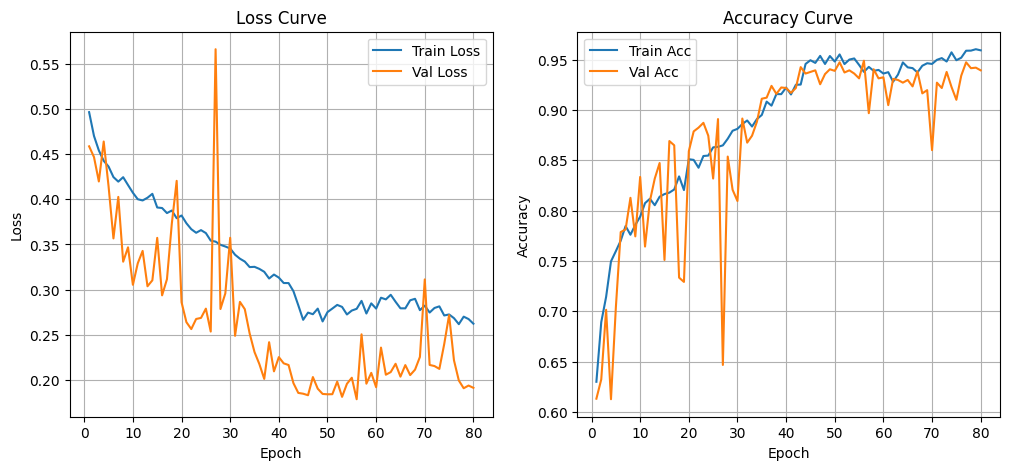

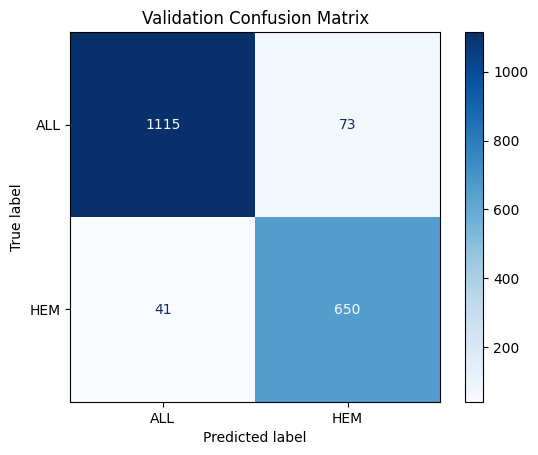

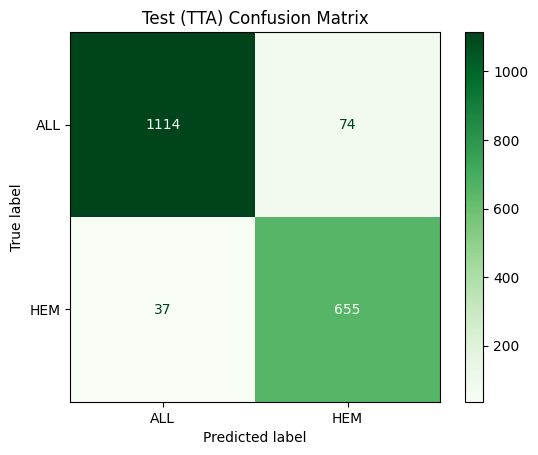

✅ Saved plots in ./checkpoints/plots


<Figure size 640x480 with 0 Axes>

In [9]:
# ============================================================
# 12) Visualization — Training, Validation & Test Results
# ============================================================
import matplotlib.pyplot as plt

# Convert history list → DataFrame
hist_df = pd.DataFrame(history)

# Plot Loss and Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist_df["epoch"], hist_df["train_loss"], label="Train Loss")
plt.plot(hist_df["epoch"], hist_df["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(hist_df["epoch"], hist_df["train_acc"], label="Train Acc")
plt.plot(hist_df["epoch"], hist_df["val_acc"], label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# Confusion Matrix (Validation + Test)
# ============================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Validation confusion matrix
cm_val = confusion_matrix(y_true_val, y_pred_val)
disp_val = ConfusionMatrixDisplay(cm_val, display_labels=["ALL", "HEM"])
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# Test confusion matrix
cm_test = confusion_matrix(y_true_tta, y_pred_tta)
disp_test = ConfusionMatrixDisplay(cm_test, display_labels=["ALL", "HEM"])
disp_test.plot(cmap="Greens")
plt.title("Test (TTA) Confusion Matrix")
plt.show()

# ============================================================
# Optional: Save Plots as PNGs
# ============================================================
plot_dir = os.path.join(SAVE_DIR, "plots")
os.makedirs(plot_dir, exist_ok=True)
plt.savefig(os.path.join(plot_dir, "loss_accuracy_curve.png"))
print(f"✅ Saved plots in {plot_dir}")


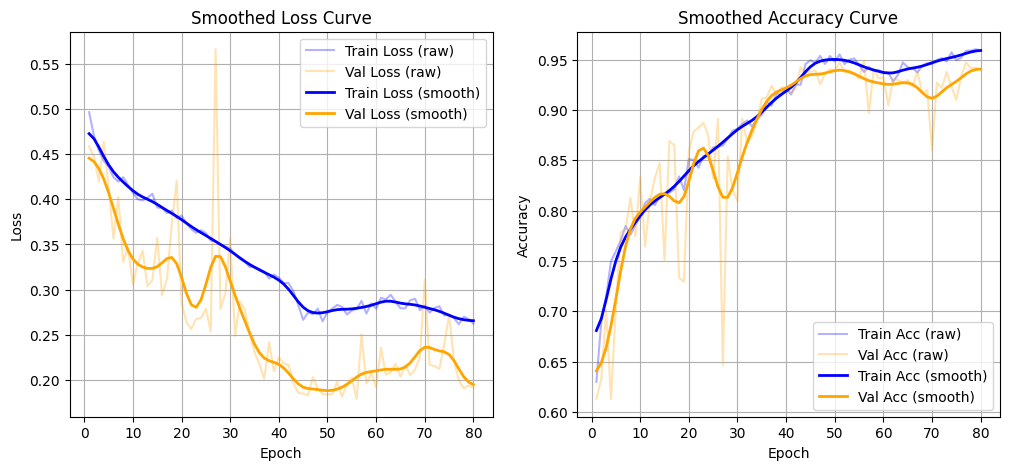

In [10]:
# ============================================================
# Smooth Training & Validation Curves (Gaussian Filter)
# ============================================================
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# Convert history to DataFrame if not already
hist_df = pd.DataFrame(history)

# Apply smoothing
sigma = 2  # higher = smoother (try 1–3)
smooth_train_loss = gaussian_filter1d(hist_df["train_loss"], sigma)
smooth_val_loss   = gaussian_filter1d(hist_df["val_loss"], sigma)
smooth_train_acc  = gaussian_filter1d(hist_df["train_acc"], sigma)
smooth_val_acc    = gaussian_filter1d(hist_df["val_acc"], sigma)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist_df["epoch"], hist_df["train_loss"], alpha=0.3, color="blue", label="Train Loss (raw)")
plt.plot(hist_df["epoch"], hist_df["val_loss"], alpha=0.3, color="orange", label="Val Loss (raw)")
plt.plot(hist_df["epoch"], smooth_train_loss, color="blue", linewidth=2, label="Train Loss (smooth)")
plt.plot(hist_df["epoch"], smooth_val_loss, color="orange", linewidth=2, label="Val Loss (smooth)")
plt.title("Smoothed Loss Curve")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(hist_df["epoch"], hist_df["train_acc"], alpha=0.3, color="blue", label="Train Acc (raw)")
plt.plot(hist_df["epoch"], hist_df["val_acc"], alpha=0.3, color="orange", label="Val Acc (raw)")
plt.plot(hist_df["epoch"], smooth_train_acc, color="blue", linewidth=2, label="Train Acc (smooth)")
plt.plot(hist_df["epoch"], smooth_val_acc, color="orange", linewidth=2, label="Val Acc (smooth)")
plt.title("Smoothed Accuracy Curve")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)
plt.show()


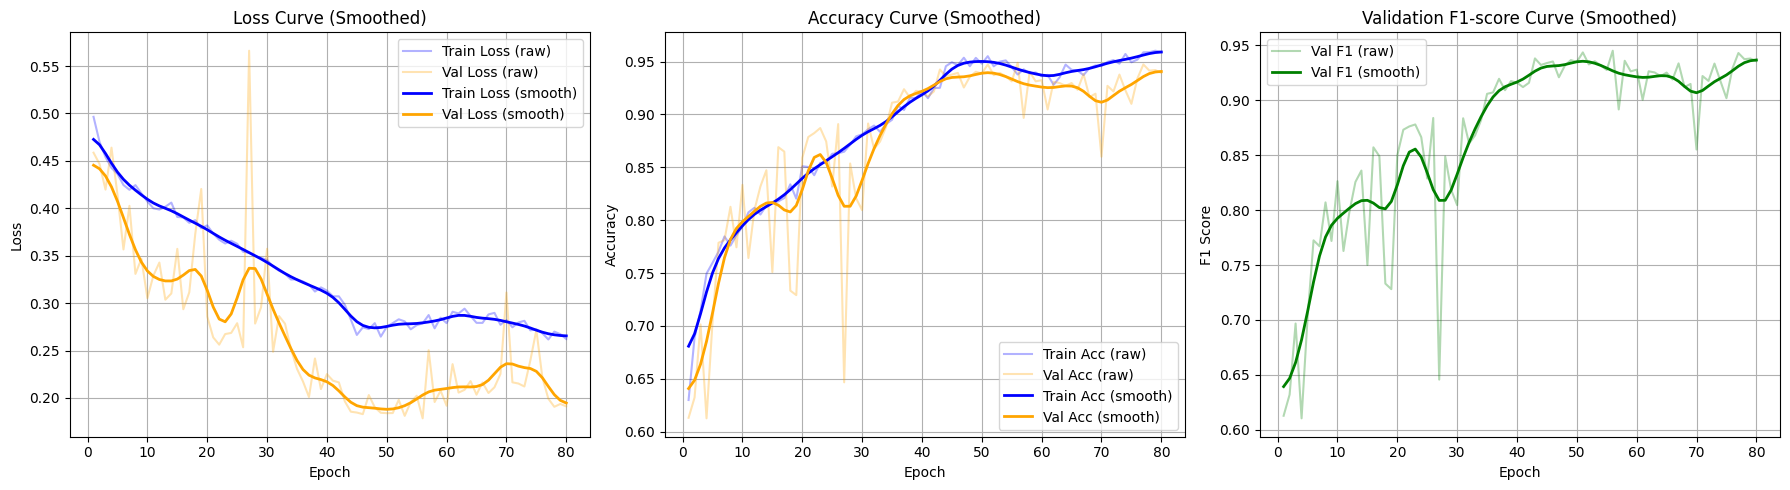

✅ Saved smoothed plots in ./checkpoints/plots


<Figure size 640x480 with 0 Axes>

In [11]:
# ============================================================
# 13) Smoothed Training Curves — Loss, Accuracy, F1 (Validation)
# ============================================================
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Convert to DataFrame (if not already)
hist_df = pd.DataFrame(history)

# Apply smoothing for clearer visualization
sigma = 2  # you can adjust between 1–3
smooth_train_loss = gaussian_filter1d(hist_df["train_loss"], sigma)
smooth_val_loss   = gaussian_filter1d(hist_df["val_loss"], sigma)
smooth_train_acc  = gaussian_filter1d(hist_df["train_acc"], sigma)
smooth_val_acc    = gaussian_filter1d(hist_df["val_acc"], sigma)
smooth_val_f1     = gaussian_filter1d(hist_df["val_f1"], sigma)

plt.figure(figsize=(18,5))

# ---------- Loss ----------
plt.subplot(1,3,1)
plt.plot(hist_df["epoch"], hist_df["train_loss"], alpha=0.3, color="blue", label="Train Loss (raw)")
plt.plot(hist_df["epoch"], hist_df["val_loss"], alpha=0.3, color="orange", label="Val Loss (raw)")
plt.plot(hist_df["epoch"], smooth_train_loss, color="blue", linewidth=2, label="Train Loss (smooth)")
plt.plot(hist_df["epoch"], smooth_val_loss, color="orange", linewidth=2, label="Val Loss (smooth)")
plt.title("Loss Curve (Smoothed)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)

# ---------- Accuracy ----------
plt.subplot(1,3,2)
plt.plot(hist_df["epoch"], hist_df["train_acc"], alpha=0.3, color="blue", label="Train Acc (raw)")
plt.plot(hist_df["epoch"], hist_df["val_acc"], alpha=0.3, color="orange", label="Val Acc (raw)")
plt.plot(hist_df["epoch"], smooth_train_acc, color="blue", linewidth=2, label="Train Acc (smooth)")
plt.plot(hist_df["epoch"], smooth_val_acc, color="orange", linewidth=2, label="Val Acc (smooth)")
plt.title("Accuracy Curve (Smoothed)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)

# ---------- F1-score ----------
plt.subplot(1,3,3)
plt.plot(hist_df["epoch"], hist_df["val_f1"], alpha=0.3, color="green", label="Val F1 (raw)")
plt.plot(hist_df["epoch"], smooth_val_f1, color="green", linewidth=2, label="Val F1 (smooth)")
plt.title("Validation F1-score Curve (Smoothed)")
plt.xlabel("Epoch"); plt.ylabel("F1 Score"); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

# ============================================================
# (Optional) Save figure
# ============================================================
plot_dir = os.path.join(SAVE_DIR, "plots")
os.makedirs(plot_dir, exist_ok=True)
plt.savefig(os.path.join(plot_dir, "smoothed_curves.png"))
print(f"✅ Saved smoothed plots in {plot_dir}")


In [13]:
!ls /kaggle/input
!ls /kaggle/input/<dataset-folder-name>


leukemia-classification
/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `ls /kaggle/input/<dataset-folder-name>'


In [14]:
!ls /kaggle/input/leukemia-classification
!ls /kaggle/input/leukemia-classification/* | head


C-NMC_Leukemia
testing_data
training_data
validation_data


In [15]:
!ls /kaggle/input/leukemia-classification/training_data


ls: cannot access '/kaggle/input/leukemia-classification/training_data': No such file or directory


In [16]:
import os
import cv2
import numpy as np
from PIL import Image
from glob import glob
from tqdm import tqdm

# ---- CONFIG ----
IMG_DIR  = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data"  # change if needed
OUT_IMG_DIR  = "./seg_dataset/train_images"
OUT_MASK_DIR = "./seg_dataset/train_masks"

os.makedirs(OUT_IMG_DIR,  exist_ok=True)
os.makedirs(OUT_MASK_DIR, exist_ok=True)

exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

# find all images in subfolders
img_paths = []
for root, dirs, files in os.walk(IMG_DIR):
    for f in files:
        if f.lower().endswith(exts):
            img_paths.append(os.path.join(root, f))

print(f"Found {len(img_paths)} images.")

for p in tqdm(img_paths):
    # read image
    img = cv2.imread(p)
    if img is None:
        continue
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)

    # apply Otsu threshold
    ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # optionally invert if background is white/foreground dark
    # thresh = cv2.bitwise_not(thresh)  # uncomment if needed

    # save original image copy
    fname = os.path.basename(p)
    cv2.imwrite(os.path.join(OUT_IMG_DIR,  fname), img)

    # save mask
    cv2.imwrite(os.path.join(OUT_MASK_DIR, fname), thresh)

print("✅ Done! Masks generated in:", OUT_MASK_DIR)


Found 10661 images.


100%|██████████| 10661/10661 [01:00<00:00, 176.23it/s]

✅ Done! Masks generated in: ./seg_dataset/train_masks


In [17]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# ---------------- CONFIG ----------------
VAL_IMG_SRC = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data"

VAL_OUT_IMG  = "./seg_dataset/val_images"
VAL_OUT_MASK = "./seg_dataset/val_masks"

os.makedirs(VAL_OUT_IMG, exist_ok=True)
os.makedirs(VAL_OUT_MASK, exist_ok=True)

exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

print("🔍 Searching validation images...")
img_paths = []
for root, dirs, files in os.walk(VAL_IMG_SRC):
    for f in files:
        if f.lower().endswith(exts):
            img_paths.append(os.path.join(root, f))
print(f"📸 Found {len(img_paths)} validation images")

# ---------------- Generate masks ----------------
for p in tqdm(img_paths):
    img = cv2.imread(p)
    if img is None:
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Otsu threshold
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # optional invert (if needed)
    # mask = cv2.bitwise_not(mask)

    fname = os.path.basename(p)
    cv2.imwrite(os.path.join(VAL_OUT_IMG, fname), img)
    cv2.imwrite(os.path.join(VAL_OUT_MASK, fname), mask)

print("\n✅ Validation masks generated successfully!")
print("Val images →", VAL_OUT_IMG)
print("Val masks  →", VAL_OUT_MASK)


🔍 Searching validation images...
📸 Found 1867 validation images


100%|██████████| 1867/1867 [00:25<00:00, 73.96it/s] 


✅ Validation masks generated successfully!
Val images → ./seg_dataset/val_images
Val masks  → ./seg_dataset/val_masks


In [20]:
# ============================================================
# Swin-UNet Segmentation — Leukemia Cells (Kaggle-ready)
# Pseudo-masks via Otsu | IMG_SIZE=384 | Dice+CE loss | TTA Eval
# ============================================================

import os, time, random, warnings
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import swin_t, Swin_T_Weights
from sklearn.metrics import jaccard_score, f1_score
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ---------------- CONFIG ----------------
SEED = 42
BATCH_SIZE = 4
EPOCHS = 40
IMG_SIZE = 384
LR = 1e-4
WEIGHT_DECAY = 1e-5
NUM_WORKERS = 4
SAVE_DIR = "/checkpoints_seg"
os.makedirs(SAVE_DIR, exist_ok=True)

# your dataset paths
TRAIN_IMG_DIR = "/kaggle/working/seg_dataset/train_images"
TRAIN_MASK_DIR = "/kaggle/working/seg_dataset/train_masks"
VAL_IMG_DIR    = "/kaggle/working/seg_dataset/val_images"
VAL_MASK_DIR   = "/kaggle/working/seg_dataset/val_masks"

# ---------------- REPRO ----------------
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(SEED)
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============================================================
# 1) Dataset
# ============================================================
class SegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform_img=None, transform_mask=None):
        self.img_dir, self.mask_dir = img_dir, mask_dir
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        self.images = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]

    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        img_path  = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        mask  = Image.open(mask_path).convert("L")

        if self.transform_img:  image = self.transform_img(image)
        if self.transform_mask: mask  = self.transform_mask(mask)

        mask = (mask > 0.5).float()  # binarize
        return image, mask

# ============================================================
# 2) Transforms
# ============================================================
transform_img = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])
transform_mask = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_ds = SegDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, transform_img, transform_mask)
val_ds   = SegDataset(VAL_IMG_DIR, VAL_MASK_DIR, transform_img, transform_mask)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} images")

# ============================================================
# 3) Swin-UNet Model (Encoder = Swin-T)
# ============================================================
class SwinUNet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        base = swin_t(weights=Swin_T_Weights.IMAGENET1K_V1)
        self.encoder = nn.Sequential(*list(base.features.children()))

        # extract feature dims
        self.enc_channels = [96, 192, 384, 768]

        # simple decoder (bilinear upsampling + conv)
        self.up3 = self._upsample_block(self.enc_channels[3], self.enc_channels[2])
        self.up2 = self._upsample_block(self.enc_channels[2], self.enc_channels[1])
        self.up1 = self._upsample_block(self.enc_channels[1], self.enc_channels[0])
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(self.enc_channels[0], 64, 2, 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.out_conv = nn.Conv2d(32, num_classes, 1)

    def _upsample_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        feats = []
        for blk in self.encoder:
            x = blk(x)
            feats.append(x)

        # upsampling decoder
        x = feats[-1]
        x = self.up3(x)
        x = self.up2(x)
        x = self.up1(x)
        x = self.up0(x)
        return torch.sigmoid(self.out_conv(x))

model = SwinUNet(num_classes=1).to(device)
print("✅ Model ready — Swin-UNet backbone initialized.")

# ============================================================
# 4) Loss & Optimizer
# ============================================================
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, preds, targets):
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        dice = (2.*intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        return 1 - dice

dice_loss = DiceLoss()
bce_loss = nn.BCELoss()
def total_loss(pred, target, alpha=0.5):
    return alpha*bce_loss(pred, target) + (1-alpha)*dice_loss(pred, target)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# ============================================================
# 5) Training & Validation
# ============================================================
def evaluate(loader):
    model.eval()
    dice_scores, ious = [], []
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            preds_bin = (preds > 0.5).float()
            for p, m in zip(preds_bin, masks):
                p = p.detach().cpu().numpy().astype(bool)
                m = m.detach().cpu().numpy().astype(bool)
                dice_scores.append(f1_score(m.flatten(), p.flatten()))
                ious.append(jaccard_score(m.flatten(), p.flatten()))
    return np.mean(dice_scores), np.mean(ious)

best_dice = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = total_loss(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    val_dice, val_iou = evaluate(val_loader)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}")

    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, f"swin_unet_best_{best_dice:.4f}.pth"))
        print(f"✅ Saved best model at epoch {epoch} (Dice={best_dice:.4f})")

print("🏁 Training complete!")

# ============================================================
# 6) Visualize Results
# ============================================================
def show_sample_predictions(n=3):
    model.eval()
    imgs, masks = next(iter(val_loader))
    imgs, masks = imgs.to(device), masks.to(device)
    preds = model(imgs)
    preds_bin = (preds > 0.5).float()

    plt.figure(figsize=(12, n*4))
    for i in range(n):
        plt.subplot(n, 3, 3*i+1)
        plt.imshow(imgs[i].permute(1,2,0).cpu().numpy())
        plt.title("Image"); plt.axis("off")

        plt.subplot(n, 3, 3*i+2)
        plt.imshow(masks[i][0].cpu().numpy(), cmap='gray')
        plt.title("Mask"); plt.axis("off")

        plt.subplot(n, 3, 3*i+3)
        plt.imshow(preds_bin[i][0].cpu().numpy(), cmap='gray')
        plt.title("Prediction"); plt.axis("off")
    plt.tight_layout()
    plt.show()

show_sample_predictions(3)


Device: cuda


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
# ============================================================
# 4) Model
# ============================================================
if MODEL_CHOICE == "swin_t":
    weights = Swin_T_Weights.IMAGENET1K_V1
    model = swin_t(weights=weights)
    model_name = "swin_t"
else:
    weights = Swin_B_Weights.IMAGENET1K_V1
    model = swin_b(weights=weights)
    model_name = "swin_b"

in_features = model.head.in_features
model.head = nn.Linear(in_features, NUM_CLASSES)
model = model.to(device)
print(f"✅ Loaded model: {model_name} -> head out_features set to {NUM_CLASSES}")

# ============================================================
# 5) Hybrid Loss (Class-weighted CE + Focal)
# ============================================================
# Class weights (computed from training distribution)
_total = sum(class_counts.values())
w_all = _total / (2 * class_counts[0])
w_hem = _total / (2 * class_counts[1])

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.5):
        super().__init__()
        self.alpha, self.gamma = alpha, gamma
    def forward(self, inputs, targets):
        ce = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce)
        return (self.alpha * (1 - pt) ** self.gamma * ce).mean()

ce_loss_fn = nn.CrossEntropyLoss(
    weight=torch.tensor([w_all, w_hem], device=device, dtype=torch.float32),
    label_smoothing=LABEL_SMOOTH
)
focal_loss_fn = FocalLoss(alpha=1.0, gamma=2.5)

def hybrid_loss(outputs, targets, alpha=0.7):
    return alpha * ce_loss_fn(outputs, targets) + (1 - alpha) * focal_loss_fn(outputs, targets)

# ============================================================
# 6) MixUp / CutMix
# ============================================================
def rand_bbox(size, lam):
    W, H = size[2], size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w, cut_h = int(W * cut_rat), int(H * cut_rat)
    cx, cy = np.random.randint(W), np.random.randint(H)
    bbx1, bby1 = np.clip(cx - cut_w // 2, 0, W), np.clip(cy - cut_h // 2, 0, H)
    bbx2, bby2 = np.clip(cx + cut_w // 2, 0, W), np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def mixup_data(x, y, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    mixed_x = lam * x + (1 - lam) * x[idx, :]
    return mixed_x, y, y[idx], lam

def cutmix_data(x, y, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    y_a, y_b = y, y[idx]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[idx, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2)))
    return x, y_a, y_b, lam

# ============================================================
# 7) Optimizer + Scheduler + AMP
# ============================================================
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
steps_per_epoch = max(1, len(train_loader))
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR, steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS, pct_start=0.3, anneal_strategy='cos', final_div_factor=100
)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

# ============================================================
# 8) Training / Validation
# ============================================================
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    y_true_all, y_pred_all = [], []
    bar = tqdm(train_loader, desc=f"Train[{epoch}]")
    for imgs, labels in bar:
        imgs, labels = imgs.to(device), labels.to(device)
        mixed = False
        if random.random() < MIXUP_PROB:
            imgs, y_a, y_b, lam = (cutmix_data(imgs, labels) if USE_CUTMIX else mixup_data(imgs, labels))
            mixed = True

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            outputs = model(imgs)
            if mixed:
                loss = lam * hybrid_loss(outputs, y_a) + (1 - lam) * hybrid_loss(outputs, y_b)
            else:
                loss = hybrid_loss(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item() * imgs.size(0)
        if not mixed:
            preds = outputs.argmax(dim=1)
            y_true_all.extend(labels.detach().cpu().numpy())
            y_pred_all.extend(preds.detach().cpu().numpy())
        bar.set_postfix({'loss': f"{running_loss / ((bar.n+1)*BATCH_SIZE):.4f}"})
    return running_loss / len(train_dataset), (accuracy_score(y_true_all, y_pred_all) if y_true_all else 0.0)

def validate(epoch, loader=val_loader):
    model.eval()
    running_loss = 0.0
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc=f"Val[{epoch}]"):
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
                outputs = model(imgs)
                loss = hybrid_loss(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            y_true.extend(labels.detach().cpu().numpy())
            y_pred.extend(preds.detach().cpu().numpy())
    return (running_loss / len(loader.dataset),
            accuracy_score(y_true, y_pred),
            f1_score(y_true, y_pred, average='macro'),
            y_true, y_pred)

# ============================================================
# 9) Test-Time Augmentation (8-way)
# ============================================================
def tta_predict(loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="TTA Predict"):
            imgs, labels = imgs.to(device), labels.to(device)
            aug_imgs = [
                imgs,
                torch.flip(imgs, dims=[3]),
                imgs.rot90(1, [2,3]),
                torch.flip(imgs.rot90(1,[2,3]), dims=[3]),
                imgs.rot90(2, [2,3]),
                torch.flip(imgs.rot90(2,[2,3]), dims=[3]),
                imgs.rot90(3, [2,3]),
                torch.flip(imgs.rot90(3,[2,3]), dims=[3]),
            ]
            out_sum = 0
            for im in aug_imgs:
                with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
                    out_sum = out_sum + model(im)
            preds = out_sum.argmax(dim=1).detach().cpu().numpy()
            y_true.extend(labels.detach().cpu().numpy())
            y_pred.extend(preds)
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro'), y_true, y_pred

# ============================================================
# ============================================================
# 10) Training Loop — Resume Supported + Auto-Save Every 5 Epochs
# ============================================================

best_val_acc, history, start_epoch = -1.0, [], 1
ckpt_files = sorted([p for p in os.listdir(SAVE_DIR) if p.startswith(model_name) and p.endswith(".pth")])

# ✅ Try to resume from latest checkpoint
if ckpt_files:
    latest_ckpt = os.path.join(SAVE_DIR, ckpt_files[-1])
    print(f"🔄 Found checkpoint: {latest_ckpt}, loading to resume training...")
    data = torch.load(latest_ckpt, map_location=device, weights_only=False)
    model.load_state_dict(data["model_state"])
    if "history" in data:
        history = data["history"]
    if "best_val_acc" in data:
        best_val_acc = data["best_val_acc"]
    if "epoch" in data:
        start_epoch = data["epoch"] + 1
    print(f"✅ Resumed from epoch {start_epoch-1} | best_val_acc={best_val_acc:.4f}")
else:
    print("🚀 Starting fresh training...")

# ============================================================
# Training Loop
# ============================================================
for epoch in range(start_epoch, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(epoch)
    val_loss, val_acc, val_f1, y_true, y_pred = validate(epoch)

    print(f"Epoch {epoch}/{EPOCHS} | Train loss {train_loss:.4f}, acc {train_acc:.4f} | "
          f"Val loss {val_loss:.4f}, acc {val_acc:.4f}, f1 {val_f1:.4f}")

    history.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1
    })

    # ✅ Save best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = os.path.join(SAVE_DIR, f"{model_name}_best_acc_{best_val_acc:.4f}.pth")
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "best_val_acc": best_val_acc,
            "history": history
        }, save_path)
        print("✅ Saved Best Model:", save_path)

    # ✅ Save progress every 5 epochs for safety
    if epoch % 5 == 0:
        save_path = os.path.join(SAVE_DIR, f"{model_name}_epoch{epoch}.pth")
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "best_val_acc": best_val_acc,
            "history": history
        }, save_path)
        print(f"💾 Progress saved at epoch {epoch}: {save_path}")

print("🏁 Training complete!")

# ============================================================
# 11) Final Evaluation — Validation + Test Reports
# ============================================================
best_ckpt = sorted([p for p in os.listdir(SAVE_DIR) if p.startswith(model_name) and p.endswith(".pth")])
if best_ckpt:
    ckpt_path = os.path.join(SAVE_DIR, best_ckpt[-1])
    print("Loading best checkpoint:", ckpt_path)
    data = torch.load(ckpt_path, map_location=device, weights_only=False)  # ✅ PyTorch 2.6 fix
    model.load_state_dict(data["model_state"])
    print(f"✅ Loaded checkpoint with best ACC={data.get('best_val_acc', 0):.4f}")
else:
    print("⚠️ No checkpoint found in", SAVE_DIR)

# ✅ Validation evaluation report
val_loss, val_acc, val_f1, y_true_val, y_pred_val = validate("final_val", loader=val_loader)
print(f"\nValidation — loss: {val_loss:.4f}, acc: {val_acc:.4f}, f1: {val_f1:.4f}")
print("Validation Classification Report:\n", classification_report(y_true_val, y_pred_val))

# ✅ Test evaluation report (with 8-way TTA)
test_acc, test_f1, y_true_tta, y_pred_tta = tta_predict(test_loader)
print(f"\nTest (TTA) — acc: {test_acc:.4f}, f1: {test_f1:.4f}")
print("Test Classification Report (TTA):\n", classification_report(y_true_tta, y_pred_tta))

# ✅ Save predictions CSV
out_df = pd.DataFrame({"true": y_true_tta, "pred": y_pred_tta})
out_path = os.path.join(SAVE_DIR, f"{model_name}_test_predictions.csv")
out_df.to_csv(out_path, index=False)
print("\n✅ Saved predictions CSV at:", out_path)
print("✅ All evaluation steps complete.")
